In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


df1 = pd.read_csv('HoC-GE2024-results-by-candidate.csv')
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ONS ID                                 4515 non-null   object 
 1   ONS region ID                          4507 non-null   object 
 2   Constituency name                      4515 non-null   object 
 3   County name                            0 non-null      float64
 4   Region name                            4515 non-null   object 
 5   Country name                           4515 non-null   object 
 6   Constituency type                      4515 non-null   object 
 7   Party name                             4515 non-null   object 
 8   Party abbreviation                     4515 non-null   object 
 9   Electoral Commission party ID          4055 non-null   object 
 10  MNIS party ID                          4515 non-null   int64  
 11  Elec

In [ ]:
df2 = pd.read_csv('HoC-GE2024-results-by-constituency.csv')

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ONS ID                 650 non-null    object 
 1   ONS region ID          650 non-null    object 
 2   Constituency name      650 non-null    object 
 3   County name            0 non-null      float64
 4   Region name            650 non-null    object 
 5   Country name           650 non-null    object 
 6   Constituency type      650 non-null    object 
 7   Declaration time       0 non-null      float64
 8   Member first name      650 non-null    object 
 9   Member surname         650 non-null    object 
 10  Member gender          650 non-null    object 
 11  Result                 650 non-null    object 
 12  First party            650 non-null    object 
 13  Second party           650 non-null    object 
 14  Electorate             650 non-null    int64  
 15  Valid 

In [ ]:
class CustomLinearRegression:
    def __init__(self, x_entries, y_entries):
        self.x_entries = x_entries
        self.y_entries = y_entries

        self.w0 = self.w1 = 0

        self.new_y_entries = []

        self.mse = None
        self.rmse = None
        self.mae = None
        self.mape = None
        self.r2 = None

        self.get_linear_regression()
        self.get_metrics()

    def get_gradient(self, x, y, w0, w1):
        n = len(x)
        gr_w0 = (1/n) * np.sum([w0 + w1 * x[i] - y[i] for i in range(n)])
        gr_w1 = (1/n) * np.sum([(w0 + w1 * x[i] - y[i]) * x[i] for i in range(n)])
        return [gr_w0, gr_w1]

    def get_line_y(self, w0, w1, x):
        return w1 * x + w0

    def get_linear_regression(self):
        e = 0.00001
        eta = 0.1
        while True:
            if abs(self.w0)>10000:
                raise Exception('Overflow')
            [gr_w0, gr_w1] = self.get_gradient(self.x_entries, self.y_entries, self.w0, self.w1)
            if np.max(np.abs(np.array([gr_w0, gr_w1]))) < e:
                break
            else:
                self.w0 = self.w0 - eta * gr_w0
                self.w1 = self.w1 - eta * gr_w1

        self.new_y_entries = self.get_line_y(self.w0, self.w1, self.x_entries)

    def get_metrics(self):
        n = len(self.x_entries)
        self.mse = 1/n * np.sum((self.y_entries-self.new_y_entries)**2)
        self.rmse = np.sqrt(self.mse)
        self.mae = 1/n * np.sum(np.abs(self.y_entries-self.new_y_entries))
        self.mape = 100/n * np.sum(np.abs((self.y_entries-self.new_y_entries)/self.y_entries))
        new_y_entries_mean = np.mean(self.new_y_entries)
        self.r2 = 1 - (np.sum((self.y_entries-self.new_y_entries)**2) / np.sum((self.y_entries-new_y_entries_mean)**2))

    def print_metrics(self):
        print('MSE', self.mse)
        print('RMSE', self.rmse)
        print('MAE', self.mae)
        print('MAPE', self.mape)
        print('R2', self.r2)
        print('Model Parameters', self.w0, self.w1)

    def plot(self):
        x_line = np.arange(min(self.x_entries), max(self.x_entries), 0.01)
        y_line = self.get_line_y(self.w0, self.w1, x_line)
        plt.plot(x_line, y_line, color='red')

Getting percentage shares of each party within constituency, instead of their vote count

In [ ]:
shares_by_party = df2.copy()
list_of_party_columns = ['Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'APNI', 'All other candidates', 'Of which other winner']
for party in list_of_party_columns:
    shares_by_party[party] = shares_by_party[party]/shares_by_party['Valid votes']

If we take results within London, there is a pretty strong 0.72 correlation between the Labour Party and the Green Party. This is because Labour is a centre-left party, and green is left-wing party, which means that Greens tend to do best, where there are more left-leaning voters to convince to vote further-left.

            Con       Lab        LD       RUK     Green
Con    1.000000 -0.553655 -0.012161  0.424760 -0.748521
Lab   -0.553655  1.000000 -0.615104 -0.381731  0.721070
LD    -0.012161 -0.615104  1.000000 -0.056601 -0.235601
RUK    0.424760 -0.381731 -0.056601  1.000000 -0.435776
Green -0.748521  0.721070 -0.235601 -0.435776  1.000000

MSE 0.0012592293268426028
RMSE 0.03548562140984152
MAE 0.029169617416566984
MAPE 33.505889348027054
R2 0.5199380199214148
Model Parameters -0.026472182654033605 0.29542424027095915


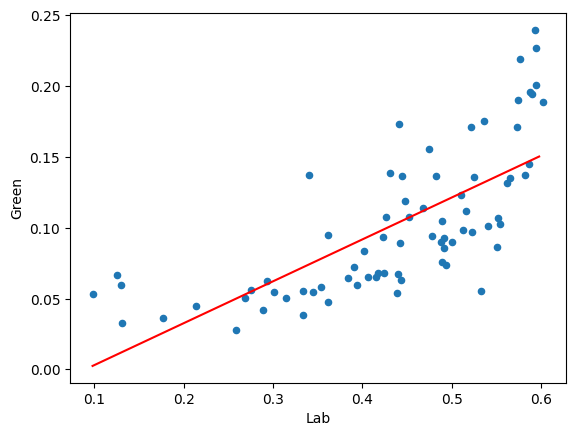

In [ ]:
print(shares_by_party[['Con', 'Lab', 'LD', 'RUK', 'Green']][shares_by_party['Region name']=='London'].corr())
print()

lab_margins = shares_by_party[shares_by_party['Region name']=='London']['Lab'].values
green_margins = shares_by_party[shares_by_party['Region name']=='London']['Green'].values
ld_margins = shares_by_party[shares_by_party['Region name']=='London']['LD'].values
con_margins = shares_by_party[shares_by_party['Region name']=='London']['Con'].values
ruk_margins = shares_by_party[shares_by_party['Region name']=='London']['RUK'].values


shares_by_party[shares_by_party['Region name']=='London'].plot.scatter(x='Lab', y='Green')
regression_obj = CustomLinearRegression(lab_margins, green_margins)
regression_obj.print_metrics()
regression_obj.plot()

Same thing, but done with scikit

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def print_metrics(y_true, y_pred):
    print(f'MSE:  {mean_squared_error(y_true, y_pred):.3f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.3f}')
    print(f'MAE:  {mean_absolute_error(y_true, y_pred):.3f}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred):.3f}')
    print(f'R2:   {r2_score(y_true, y_pred):.3f}')

lab_margins_reshaped = lab_margins.reshape(-1, 1)
green_margins_reshaped = green_margins.reshape(-1, 1)
ld_margins_reshaped = ld_margins.reshape(-1, 1)
con_margins_reshaped = con_margins.reshape(-1, 1)
ruk_margins_reshaped = ruk_margins.reshape(-1, 1)


lr = LinearRegression()
lr.fit(lab_margins_reshaped, green_margins_reshaped)
y_pred = lr.predict(lab_margins_reshaped)

In [ ]:
print('My implementation:')
regression_obj.print_metrics()

print('')
print('Scikit implementation:')
print('Training error:')
print_metrics(green_margins_reshaped, lr.predict(lab_margins_reshaped))

print()
print('Model parameters:')
print(lr.intercept_, lr.coef_)

My implementation:
MSE 0.0012592293268426028
RMSE 0.03548562140984152
MAE 0.029169617416566984
MAPE 33.505889348027054
R2 0.5199380199214148
Model Parameters -0.026472182654033605 0.29542424027095915

Scikit implementation:
Training error:
MSE:  0.001
RMSE: 0.035
MAE:  0.029
MAPE: 0.335
R2:   0.520

Model parameters:
[-0.02681061] [[0.29619096]]


A few more linear regression examples.

Conservative and Greens have strong negative correlation, and it's pretty consistent that it's pretty easy to 'guess' the result.


Conservative and Green:
MSE 0.0011534070201460861
RMSE 0.033961846536165935
MAE 0.02625840457925572
MAPE 33.632232962717076
R2 0.5602811582009257
Model Parameters 0.16951486964909276 -0.3337085824732215


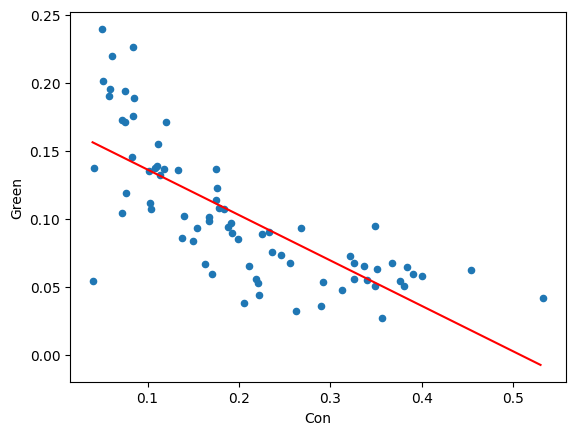

In [ ]:
print('Conservative and Green:')
shares_by_party[shares_by_party['Region name']=='London'].plot.scatter(x='Con', y='Green')
regression_obj = CustomLinearRegression(con_margins, green_margins)
regression_obj.print_metrics()
regression_obj.plot()

Conservatives and Liberal Democrats have no correlation (lib dems mostly do poorly, but there are some seats where they won, some where they are 2nd against labour, and some, where they are 2nd against conservatives). We would likely be able to guess the result if not for the existing outliers.

Conservative and Liberal Democrat:
MSE 0.013748323724137984
RMSE 0.11725324611343596
MAE 0.06740252625104755
MAPE 85.0876905492784
R2 0.00014729563668736123
Model Parameters 0.10747609242742388 -0.011651096161482298


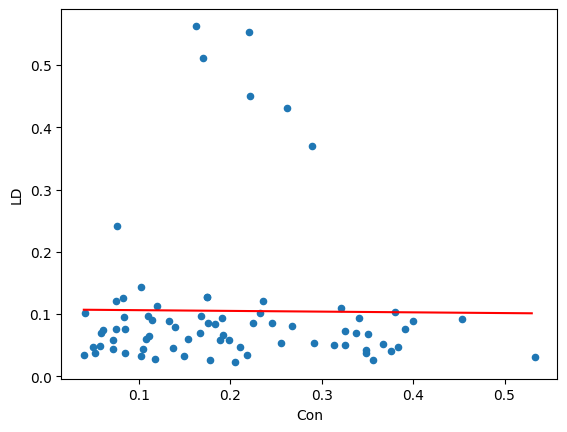

In [ ]:
print('Conservative and Liberal Democrat:')
shares_by_party[shares_by_party['Region name']=='London'].plot.scatter(x='Con', y='LD')
regression_obj = CustomLinearRegression(con_margins, ld_margins)
regression_obj.print_metrics()
regression_obj.plot()

Liberal Democrats and Greens have weak negative correlation, and while it is very difficult to guess the result, metrics don't appear to be too awful, especially in comparison to the previous one.

Liberal Democrat and Green:
MSE 0.0024774635039354087
RMSE 0.04977412484349081
MAE 0.04025683165173856
MAPE 49.507418161249184
R2 0.05550480898630228
Model Parameters 0.11295964114693667 -0.10216716809938474


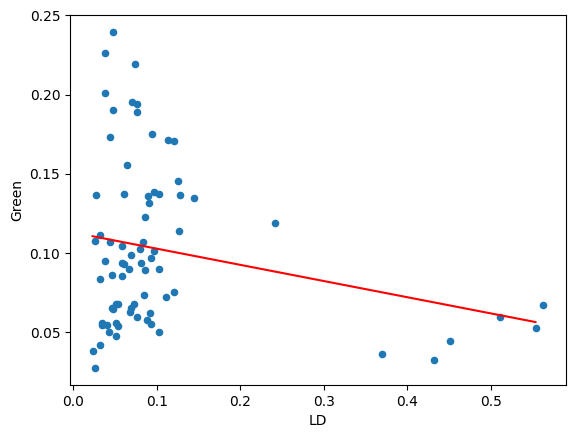

In [ ]:
print('Liberal Democrat and Green:')
shares_by_party[shares_by_party['Region name']=='London'].plot.scatter(x='LD', y='Green')
regression_obj = CustomLinearRegression(ld_margins, green_margins)
regression_obj.print_metrics()
regression_obj.plot()

Training and evaluating the linear-regression model using k-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

print(shares_by_party[['Con', 'Lab', 'LD', 'RUK', 'Green']][shares_by_party['Region name']=='London'].corr())
print()

def rmse(model, X, y):
    return np.sqrt(mean_squared_error(y, model.predict(X)))

n_folds = 5

model = LinearRegression()

scores = cross_val_score(model, lab_margins_reshaped, green_margins_reshaped, cv=n_folds, scoring=rmse)

print('Labour and Green:')
print(scores)
print('Total:', scores.mean())
print()

scores = cross_val_score(model, con_margins_reshaped, green_margins_reshaped, cv=n_folds, scoring=rmse)

print('Conservative and Green:')
print(scores)
print('Total:', scores.mean())
print()

scores = cross_val_score(model, con_margins_reshaped, ld_margins_reshaped, cv=n_folds, scoring=rmse)

print('Conservative and Liberal Democrat:')
print(scores)
print('Total:', scores.mean())
print()

scores = cross_val_score(model, ld_margins_reshaped, green_margins_reshaped, cv=n_folds, scoring=rmse)

print('Liberal Democrat and Green:')
print(scores)
print('Total:', scores.mean())

            Con       Lab        LD       RUK     Green
Con    1.000000 -0.553655 -0.012161  0.424760 -0.748521
Lab   -0.553655  1.000000 -0.615104 -0.381731  0.721070
LD    -0.012161 -0.615104  1.000000 -0.056601 -0.235601
RUK    0.424760 -0.381731 -0.056601  1.000000 -0.435776
Green -0.748521  0.721070 -0.235601 -0.435776  1.000000

Labour and Green:
[0.03189117 0.03056143 0.04401388 0.03998635 0.0418947 ]
Total: 0.03766950557689936

Conservative and Green:
[0.02039007 0.023702   0.04309476 0.04147758 0.03669708]
Total: 0.03307229656775382

Conservative and Liberal Democrat:
[0.09941702 0.053646   0.06423557 0.11058926 0.21196605]
Total: 0.10797077958660843

Liberal Democrat and Green:
[0.04405173 0.0330623  0.06245679 0.05987262 0.0526593 ]
Total: 0.050420550856772495
